In [28]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from helpers.items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
from helpers.testing import Tester



A model that can estimate how much something costs, from its description.

In [12]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [15]:
openai = OpenAI()
claude = Anthropic()

In [16]:
%matplotlib inline

In [17]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

using GPT-4o-mini

In [19]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [20]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nThe Phantom of the Opera Gaston Leroux Clay Mini Book Key Chain Ring Bag Purse Backpack Clip Snap\n“I tore off my mask so as not to lose one of her tears... and she did not run away!” Wouldn't you like a more effective way to keep track of your bag? This clay mini book pendant provides a durable, lightweight accessory to mark your satchel, purse or backpack. Both eye-catching and trendy, the stunning cover makes it easy to locate your belongings. VERSATILE it doubles as a lovely key chain or key ring.Treat yourself to a Book Beads adaptation of a novel which was first serialized in La Gaulois (1909) and remains a musical classic to this day. It's the perfect bookish accessory! HANDMADE IN THE USA when"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [21]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [22]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [23]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [24]:
test[0].price

35.0

1: Guess: $12.99 Truth: $35.00 Error: $22.01 SLE: 0.89 Item: The Phantom of the Opera Gaston Leroux C...
2: Guess: $47.99 Truth: $135.99 Error: $88.00 SLE: 1.06 Item: Norcold 628970 Fridge Part
3: Guess: $139.99 Truth: $178.43 Error: $38.44 SLE: 0.06 Item: SPT RF-244SS Compact Refrigerator, Stain...
4: Guess: $5.99 Truth: $6.98 Error: $0.99 SLE: 0.02 Item: Letter Red B Balloons,40 Inch Single Red...
5: Guess: $15.00 Truth: $45.99 Error: $30.99 SLE: 1.16 Item: Konami Classics Arcade Hits - Nintendo D...
6: Guess: $89.99 Truth: $88.99 Error: $1.00 SLE: 0.00 Item: Mini Washing Machine, Portable Washer fo...
7: Guess: $45.99 Truth: $104.95 Error: $58.96 SLE: 0.66 Item: Farmhouse Buffalo Plaid Wreath - Front D...
8: Guess: $30.00 Truth: $215.00 Error: $185.00 SLE: 3.77 Item: Corpse Party: Back to School Edition - N...
9: Guess: $49.99 Truth: $75.00 Error: $25.01 SLE: 0.16 Item: True leather case for Microsoft Surface ...
10: Guess: $30.00 Truth: $97.71 Error: $67.71 SLE: 1.34 Item: Virtua C

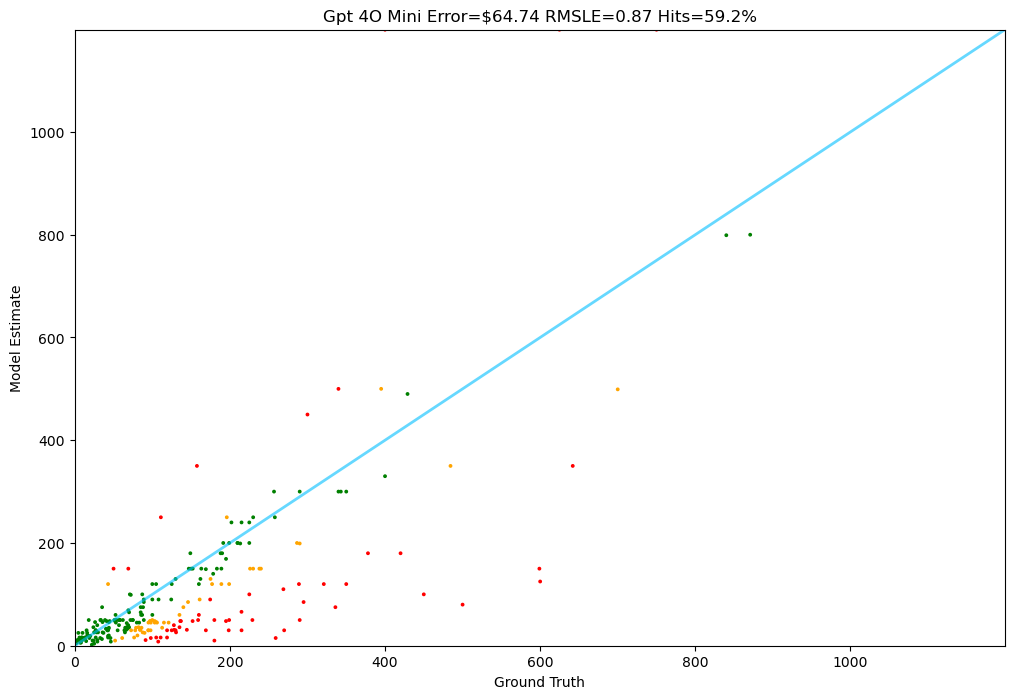

In [25]:
Tester.test(gpt_4o_mini, test)

In [26]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $19.99 Truth: $35.00 Error: $15.01 SLE: 0.29 Item: The Phantom of the Opera Gaston Leroux C...
2: Guess: $49.99 Truth: $135.99 Error: $86.00 SLE: 0.98 Item: Norcold 628970 Fridge Part
3: Guess: $119.99 Truth: $178.43 Error: $58.44 SLE: 0.16 Item: SPT RF-244SS Compact Refrigerator, Stain...
4: Guess: $4.99 Truth: $6.98 Error: $1.99 SLE: 0.08 Item: Letter Red B Balloons,40 Inch Single Red...
5: Guess: $19.99 Truth: $45.99 Error: $26.00 SLE: 0.65 Item: Konami Classics Arcade Hits - Nintendo D...
6: Guess: $59.99 Truth: $88.99 Error: $29.00 SLE: 0.15 Item: Mini Washing Machine, Portable Washer fo...
7: Guess: $49.99 Truth: $104.95 Error: $54.96 SLE: 0.53 Item: Farmhouse Buffalo Plaid Wreath - Front D...
8: Guess: $39.99 Truth: $215.00 Error: $175.01 SLE: 2.76 Item: Corpse Party: Back to School Edition - N...
9: Guess: $59.99 Truth: $75.00 Error: $15.01 SLE: 0.05 Item: True leather case for Microsoft Surface ...
10: Guess: $49.99 Truth: $97.71 Error: $47.72 SLE: 0.44 Item: Virtua 

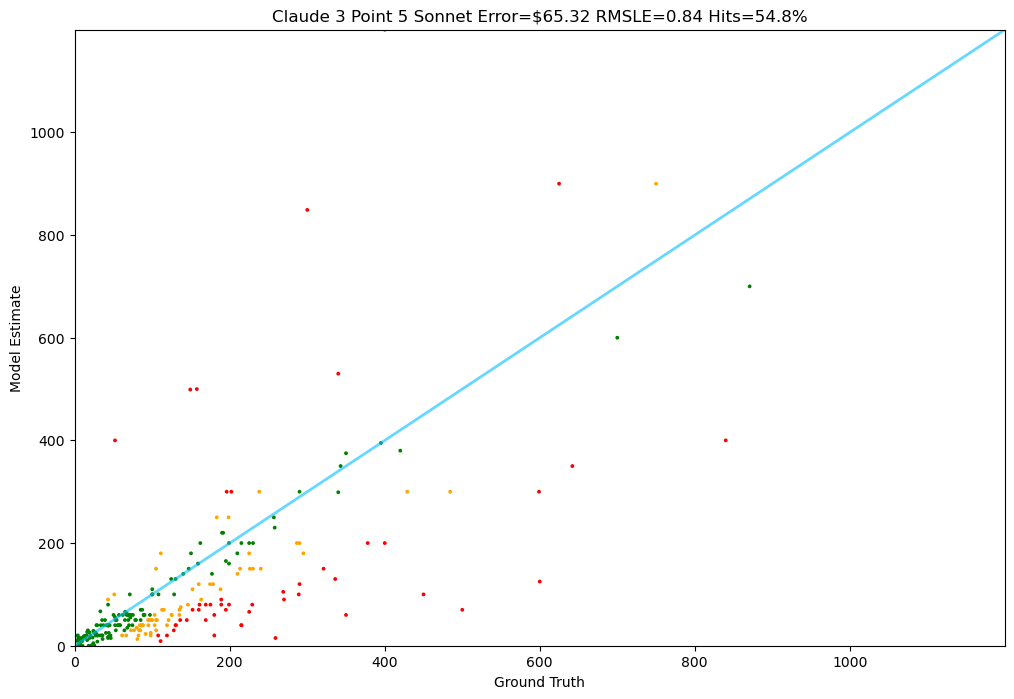

In [27]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)